In [1]:
# https://stats.stackexchange.com/questions/190148/building-an-autoencoder-in-tensorflow-to-surpass-pca

## Initialization

In [2]:
# numba will clear GPU memory
from numba import cuda
cuda.select_device(0)

%matplotlib notebook

import pylab as plt
import numpy as np
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

Using TensorFlow backend.


## PCA

In [3]:
# mu = x_train.mean(axis=0)
# U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
# Zpca = np.dot(x_train - mu, V.transpose())

# Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
# err = np.sum((x_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
# print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

pca = PCA(n_components=2)
Zpca = pca.fit_transform(x_train)
Rpca = pca.inverse_transform(Zpca)
err = mean_squared_error(x_train, Rpca)
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

PCA reconstruction error with 2 PCs: 0.056


## Training the autoencoder

In [4]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(784,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(784,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1, 
                validation_data=(x_test, x_test))

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = m.predict(x_train)        # reconstruction

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.0557 - val_loss: 0.0496
Epoch 2/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0472 - val_loss: 0.0455
Epoch 3/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0444 - val_loss: 0.0434
Epoch 4/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0428 - val_loss: 0.0427
Epoch 5/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.0417 - val_loss: 0.0416


## Plotting PCA projection side-by-side with the bottleneck representation

<IPython.core.display.Javascript object>


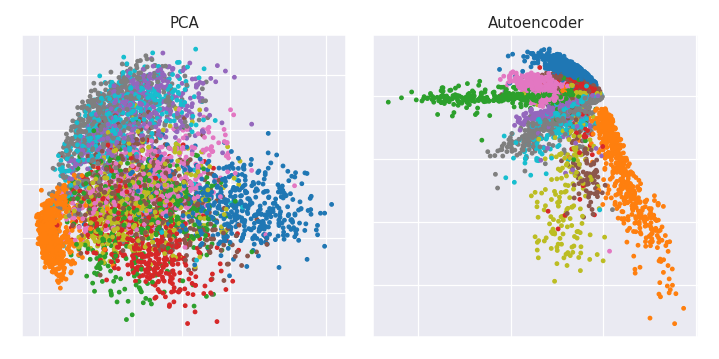

In [5]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PCA')
plt.scatter(Zpca[:5000,0], Zpca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

## Reconstructions

<IPython.core.display.Javascript object>


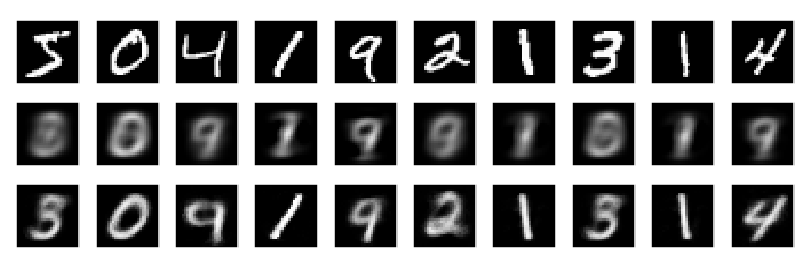

In [6]:
plt.figure(figsize=(9,3))
toPlot = (x_train, Rpca, Renc)
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [7]:
cuda.close()